<a href="https://colab.research.google.com/github/yanetniguse/LinguaFusion/blob/main/Copy_of_machine_translation_from_english_to_amharic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **machine translation from english to amharic**

YANET NUGUSE TESFAY------670530

FIYORI ZEMICHEAL TEKLU-----670422



Business Value of Machine Translation (MT) for SDGs Machine Translation (MT) technologies, powered by machine learning, provide transformative value in addressing the United Nations' Sustainable Development Goals (SDGs):

**SDG 4: Quality Education**

Impact: Breaks language barriers to make education accessible globally. Value: Enables cost-effective localization of e-learning resources and supports global knowledge-sharing platforms.

**SDG 8: Decent Work and Economic Growth**

Impact: Facilitates global trade and remote work opportunities. Value: Boosts market reach for businesses, enhances multilingual customer interaction, and supports gig economy platforms.

**SDG 10: Reduced Inequalities**

Impact: Promotes inclusivity for underserved communities. Value: Makes services accessible in local languages, strengthening CSR and brand loyalty.

**SDG 16: Peace, Justice, and Strong Institutions**

Impact: Supports communication in humanitarian and legal systems. Value: Enables real-time translation for diplomacy, emergency response, and international collaboration.

**SDG 17: Partnerships for the Goals**

Impact: Enhances global partnerships through seamless multilingual communication. Value: Reduces costs for cross-border collaborations and fosters innovation. Broader Business Benefits

Revenue Growth: Expands access to international markets. Cost Efficiency: Automates repetitive translation tasks. Customer Satisfaction: Personalizes experiences for global users. Innovation: Powers AI chatbots and virtual assistants. CSR and Branding: Demonstrates commitment to social impact.



What We Use

Python: Primary language for implementing the translation model and handling data processing.

Hugging Face Transformers: For pre-trained models and tokenization. PyTorch: Backend for deep learning operations. Hugging Face Datasets: Efficient handling of dataset operations.
Seq2SeqTrainer and TrainingArguments: Simplifies fine-tuning of sequence-to-sequence models. SacreBLEU: For evaluating translation accuracy using BLEU scores. Dataset Management:




imports the essential libraries needed for translation and evaluation

In [ ]:
# Installing necessary libraries for NLP and deployment
!pip install transformers datasets torch fastapi uvicorn sentencepiece

# Installing SacreBLEU for evaluating translation models
!pip install sacrebleu
!pip install sacremoses

# Importing PyTorch for deep learning operations
import torch

# Importing pandas for data manipulation and preprocessing
import pandas as pd

# Hugging Face library for handling datasets
from datasets import Dataset

# Splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split

# Hugging Face library for tokenization of text data
from transformers import AutoTokenizer


# Hugging Face Trainer and TrainingArguments for managing the training process
from transformers import Trainer, TrainingArguments

# Visualization libraries for plotting graphs and analyzing data
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from collections import Counter


# BLEU score evaluation for translation tasks
from sacrebleu import corpus_bleu

# MarianMT pre-trained translation model and tokenizer from Hugging Face
from transformers import MarianMTModel, MarianTokenizer

# Seq2SeqTrainer and Seq2SeqTrainingArguments for training sequence-to-sequence models
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Generic classes for sequence-to-sequence language models and tokenizers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

Extract Source and Target Sentences: Reads English (source) and Amharic (target) sentences from the dataset and ensures they are strings.

Tokenize Source Sentences: Converts English sentences into tokenized inputs with padding and truncation to ensure uniform sequence length.

while tokenize it changes it to small letters and encoded into numerical token IDs that the model can understand,

Padding ensures all sequences are the same length by adding extra tokens to shorter ones, while truncation shortens longer sequences to fit within the model's maximum input length.

Tokenize both Target Sentences and Source Sentence

In [ ]:
  # Load the tokenizer for the pre-trained translation model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-mul")

# Define the preprocessing function for tokenizing input and target sentences
def preprocess_function(examples):
    # Extract English (source) sentences and ensure they are strings
    english_sentences = [str(sentence) for sentence in examples["English Sentence"]]

    # Extract Amharic (target) sentences and ensure they are strings
    amharic_sentences = [str(sentence) for sentence in examples["Amharic Sentence"]]

    # Tokenize the English sentences (source)
    # - Adds padding to make sequences of equal length
    # - Truncates to fit within the maximum sequence length
    model_inputs = tokenizer(
        english_sentences,
        padding='max_length',
        truncation=True,
        max_length=512
    )

    # Tokenize the Amharic sentences (target)
    # - Switch the tokenizer into target tokenization mode
    # - Similar padding and truncation applied for target sentences
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            amharic_sentences,
            padding='max_length',
            truncation=True,
            max_length=512
        )

    # Add the tokenized Amharic sentences as labels (target outputs)
    model_inputs['labels'] = labels['input_ids']

    # Return the preprocessed inputs with source and target tokens
    return model_inputs


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Load Dataset: Reads a CSV file (translation_neww.csv) into a Pandas DataFrame.
Split Data: Divides the dataset into:

    Training (80%)
    Validation (10%)
    Testing (10%)

Convert to Hugging Face Dataset: Converts each split into a Hugging Face Dataset object for compatibility with transformers.
Preprocess Data: Applies tokenization to the English and Amharic text in each dataset using the preprocess_function.
Clean Up Columns: Removes raw text columns, keeping only tokenized inputs (input_ids, attention_mask) and labels for training.
Set Format for PyTorch: Prepares datasets for PyTorch, making them ready for model training and evaluation with Hugging Face's Trainer API.

In [ ]:
# Load the dataset
dataset_path = "/content/translation_neww.csv"  # Make sure this path is correct
df = pd.read_csv(dataset_path)

# Split the dataset into training (80%), validation (10%), and testing (10%)
train_df, temp_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(temp_df, test_size=0.5)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply the preprocessing function (including text cleaning) to all datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Remove unnecessary columns (keeping only tokenized input and labels)
train_tokenized = train_dataset.remove_columns(["English Sentence", "Amharic Sentence"])
val_tokenized = val_dataset.remove_columns(["English Sentence", "Amharic Sentence"])
test_tokenized = test_dataset.remove_columns(["English Sentence", "Amharic Sentence"])

# Set the format for PyTorch tensors (to be compatible with Hugging Face Trainer)
train_tokenized.set_format(type="torch")
val_tokenized.set_format(type="torch")
test_tokenized.set_format(type="torch")


Map:   0%|          | 0/1624 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

This code extracts the first tokenized English (input_ids) and Amharic (labels) sentences from the training dataset, prints their first 20 token IDs, and decodes them back into text using the tokenizer. It verifies the tokenization and preprocessing process.

In [ ]:
# Get the first English sentence's token IDs
english_tokens = train_tokenized['input_ids'][0]

# Get the first Amharic sentence's token IDs
amharic_tokens = train_tokenized['labels'][0]

# Print the token IDs (you might want to limit the number printed for readability)
print("English Token IDs:", english_tokens[:20])  # Print first 20 tokens
print("Amharic Token IDs:", amharic_tokens[:20]) # Print first 20 tokens

# Decode the token IDs to see the actual text
decoded_english = tokenizer.decode(english_tokens, skip_special_tokens=True)
decoded_amharic = tokenizer.decode(amharic_tokens, skip_special_tokens=True)

print("Decoded English:", decoded_english)
print("Decoded Amharic:", decoded_amharic)

English Token IDs: tensor([   51,  9240, 48679, 21420,     8, 31335,    17, 19223,     7, 30839,
        32550, 14607,     7, 31231, 27549, 14607,    52, 10477,   209,     2])
Amharic Token IDs: tensor([ 1372, 17355,   583,  5942, 47316,  1977,  2209, 21086, 25158,  1372,
         1617, 19049,  2656,   583,     4,  2749,  3025,   510,  1001, 10600])
Decoded English: The National Veterinary Institute of Ethiopia is preparing to manufacture veterinary drugs to substitute imported drugs an official said.
Decoded Amharic: የኢትዮጵያ ብሄራዊ የእንስሳት ህክምና ኢንስቲትዩት ከውጭ የሚገቡ መድኃኒቶችን ሀገር ውስጥ በሚመረቱ መድሃኒቶች ለመቀየር በዝግጅት ላይ መሆኑን አንድ ባለሥልጣኑ ገለጸ።


This code plots histograms with KDE overlays to visualize the sentence length distributions for English and Amharic sentences in the dataset, helping analyze length variations for tokenization and model setup.

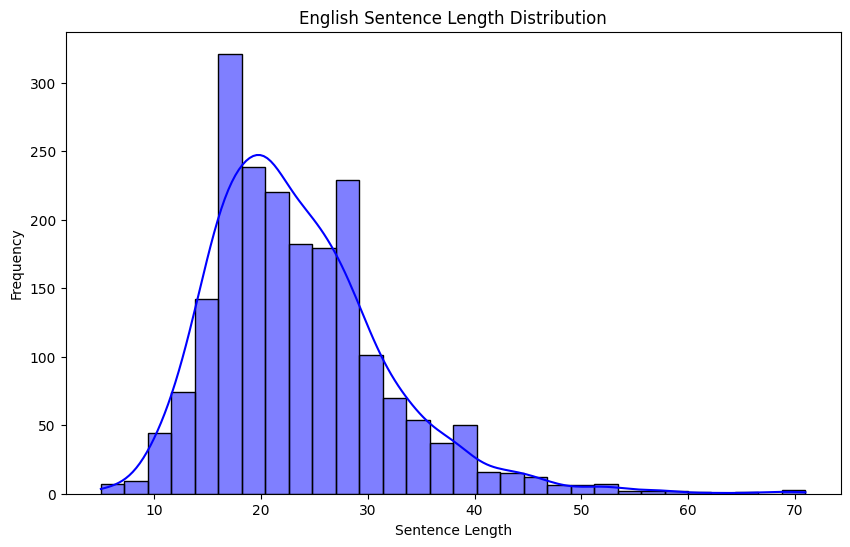

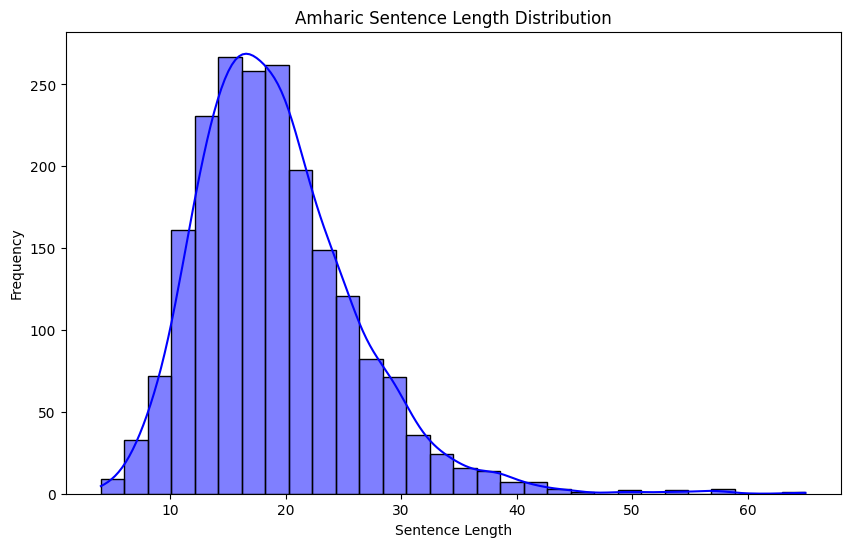

In [ ]:

# Sentence Length Distribution
def plot_sentence_length_distribution(df, col, title):
    sentence_lengths = df[col].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, kde=True, bins=30, color="blue")
    plt.title(title)
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.show()

plot_sentence_length_distribution(df, "English Sentence", "English Sentence Length Distribution")
plot_sentence_length_distribution(df, "Amharic Sentence", "Amharic Sentence Length Distribution")



this calculates and prints the vocabulary size for English and Amharic sentences by counting unique words in each language's dataset.

In [ ]:
# Vocabulary Size
def calculate_vocab_size(sentences):
    all_words = " ".join(sentences).split()
    vocab = set(all_words)
    return len(vocab)

english_vocab_size = calculate_vocab_size(df["English Sentence"].astype(str).tolist())
amharic_vocab_size = calculate_vocab_size(df["Amharic Sentence"].astype(str).tolist())

print(f"English Vocabulary Size: {english_vocab_size}")
print(f"Amharic Vocabulary Size: {amharic_vocab_size}")



English Vocabulary Size: 11505
Amharic Vocabulary Size: 15039


This code plots the top 20 most frequent words in English and Amharic sentences, visualizing word frequency with horizontal bar plots.

<ipython-input-35-40ecb424a3bc>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


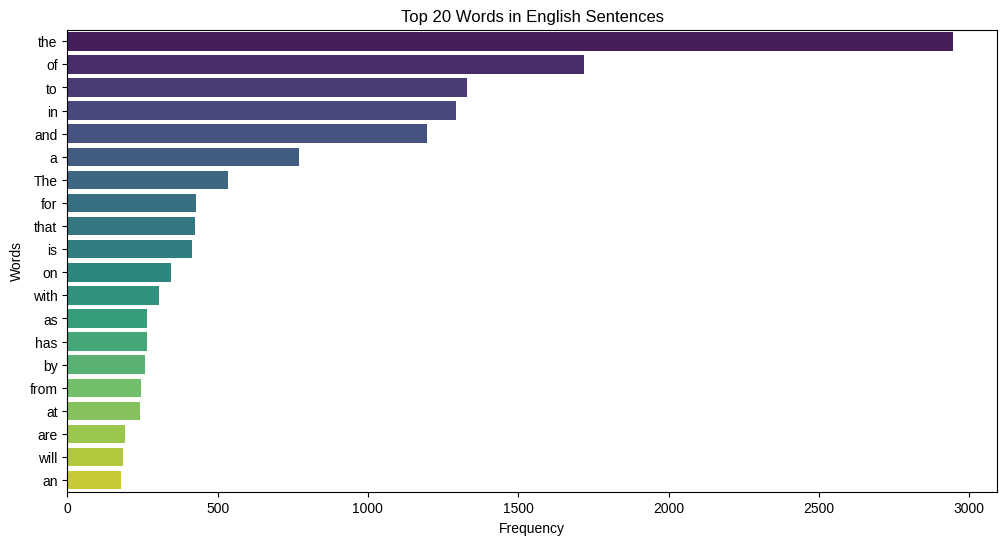

<ipython-input-35-40ecb424a3bc>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


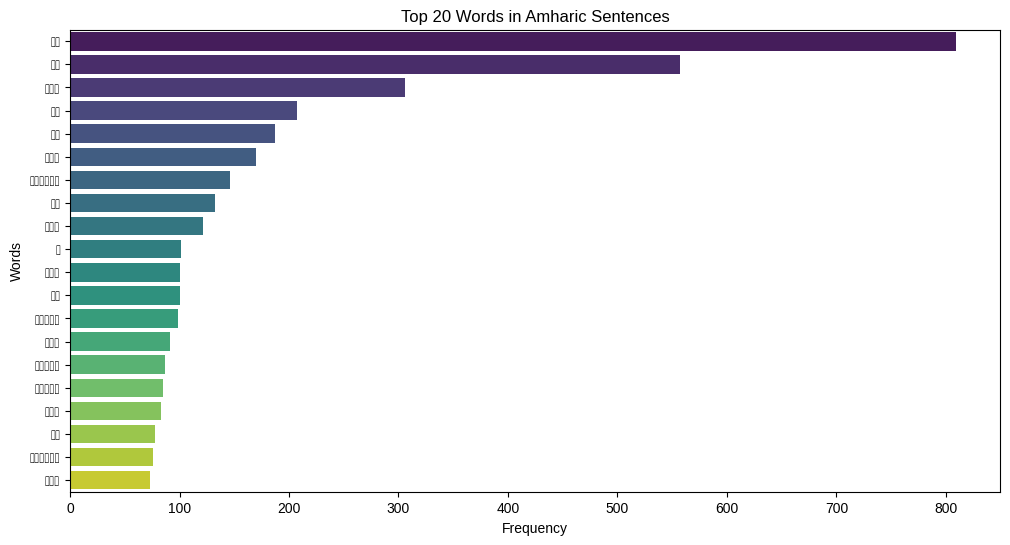

In [ ]:

from matplotlib import rcParams

# Set the font to Liberation Sans (widely available in Colab)
rcParams['font.family'] = 'Liberation Sans'

# Define the function for plotting
def plot_token_frequency_distribution(sentences, title):
    from collections import Counter
    all_words = " ".join(sentences).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts, y=words, palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

# Example usage
plot_token_frequency_distribution(df["English Sentence"].astype(str).tolist(), "Top 20 Words in English Sentences")
plot_token_frequency_distribution(df["Amharic Sentence"].astype(str).tolist(), "Top 20 Words in Amharic Sentences")


Load Pre-trained MarianMT Model:
Loads the Helsinki-NLP/opus-mt-en-mul model, which is designed for multilingual translation tasks.


Set Up Training Arguments:
Configures training parameters, including batch size, learning rate, number of epochs, logging, checkpoint saving, and mixed precision training.


Initialize Seq2SeqTrainer:
Prepares the Seq2SeqTrainer with the model, training arguments, tokenized datasets (train and validation), and tokenizer.

In [ ]:
from transformers import MarianMTModel, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Load the pre-trained MarianMT model for translation
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-mul")

# Set up training arguments for the Seq2Seq model
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",                  # Directory to save results
    eval_strategy="epoch",                   # Evaluation frequency (after each epoch)
    learning_rate=3e-5,                      # Learning rate for optimizer
    per_device_train_batch_size=8,           # Batch size for training
    per_device_eval_batch_size=8,            # Batch size for evaluation
    num_train_epochs=20,                      # Number of epochs for training
    weight_decay=0.01,                       # L2 regularization
    logging_dir="./logs",                    # Directory for logs
    report_to="none",                        # Disable reporting to any dashboard
    fp16=True,                               # Enable mixed precision training
    gradient_accumulation_steps=2,           # Number of gradient accumulation steps
    save_steps=50,                         # Save checkpoints every 50 steps
    evaluation_strategy="epoch",             # Run evaluation after each epoch
)

# Initialize the Seq2SeqTrainer with model, training arguments, and tokenized datasets
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,           # Tokenized training dataset
    eval_dataset=val_tokenized,              # Tokenized validation dataset
    tokenizer=tokenizer,                     # Tokenizer for tokenizing text
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-af63ee543def>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


train the data

result:
The data shows the training and validation losses for each epoch of model training. The training loss decreases over time, indicating that the model is learning effectively. The validation loss improves as well, starting at 0.297 and reaching 0.261 at epoch 19. The final training loss is 0.2457 after 20 epochs, suggesting the model has converged and performs well on both the training and validation data. The training runtime was 435.6 seconds.

In [ ]:

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
0,No log,0.297043
2,No log,0.255326
4,0.501700,0.243544
6,0.501700,0.399389
8,0.501700,0.247504
10,0.192000,0.266388
12,0.192000,0.262751
14,0.155300,0.288310
16,0.155300,0.263044
18,0.155300,0.264701


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2020, training_loss=0.2456907310108147, metrics={'train_runtime': 435.6032, 'train_samples_per_second': 74.563, 'train_steps_per_second': 4.637, 'total_flos': 4382380617891840.0, 'train_loss': 0.2456907310108147, 'epoch': 19.901477832512317})

This code saves the trained MarianMT model and its tokenizer to the ./trained_model directory for future use.

In [ ]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/source.spm',
 './trained_model/target.spm',
 './trained_model/added_tokens.json')

valuates the trained model on the test datase

and the result
 show that the trained model achieved a loss of 0.233, processed 258 samples per second, and completed evaluation steps at 33.1 steps per second. The evaluation occurred at approximately epoch 19.9, indicating a fast and efficient evaluation with relatively low loss.

In [ ]:
# Evaluate the trained model on the test dataset
test_results = trainer.evaluate(test_tokenized)
print(test_results)

{'eval_loss': 0.2330232411623001, 'eval_runtime': 0.7856, 'eval_samples_per_second': 258.403, 'eval_steps_per_second': 33.096, 'epoch': 19.901477832512317}


It loads the trained model and tokenizer, then tokenizes new input data, performs the translation, and decodes the output to produce the translated text.

In [ ]:
model = MarianMTModel.from_pretrained("/content/trained_model")
tokenizer = MarianTokenizer.from_pretrained("/content/trained_model")
# Define a function to translate text
def translate(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Perform the translation
    outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Decode the translated text
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Test the translation function
english_sentence = "my name is fiyori and I live in kenya."
translated_sentence = translate(english_sentence)
print(f"Translated sentence: {translated_sentence}")

Translated sentence: ስሜ ፊዮሪ እና እኔ በኬንያ እየኖረሁ ነው።


This code loads a trained translation model, generates translations for the test dataset, and calculates the BLEU score to evaluate the translation quality by comparing the generated translations to the reference translations.


the result indicates a BLEU score of 38.06 indicates a moderate to good quality of translation from English to Amharic.

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
from sacrebleu import corpus_bleu

# Load the trained model and tokenizer
model = MarianMTModel.from_pretrained("./trained_model")
tokenizer = MarianTokenizer.from_pretrained("./trained_model")

# Define a function to generate translations for the test dataset
def generate_translation(input_sentence):
    # Tokenize the input sentence
    inputs = tokenizer(input_sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Generate translation
    translated = model.generate(**inputs)
    # Decode the generated tokens to get the translated text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

# Generate translations for the test set
generated_translations = []
reference_translations = []

for sample in test_dataset:
    # Ensure input sentence is a string
    english_sentence = str(sample["English Sentence"])
    reference_sentence = str(sample["Amharic Sentence"])
    # Generate translation
    generated_translation = generate_translation(english_sentence)
    generated_translations.append(generated_translation)

    # Append the reference (as a list of one item)
    reference_translations.append([reference_sentence])

# Calculate BLEU score
bleu_score = corpus_bleu(generated_translations, reference_translations)

# Print the BLEU score
print(f"BLEU Score: {bleu_score.score}")


BLEU Score: 38.058030016749456


This code displays the first 5 English sentences from the test set, along with their reference Amharic translations and the model's translations for comparison

In [ ]:
# Display some samples
for i in range(3):
    print(f"English Sentence: {test_df.iloc[i]['English Sentence']}")
    print(f"Reference Translation (Amharic): {test_df.iloc[i]['Amharic Sentence']}")
    print(f"Model Translation: {generate_translation(test_df.iloc[i]['English Sentence'])}")
    print("-" * 80)


English Sentence: Design Week Addis Ababa is an internationally recognized design and innovation event in Ethiopia.
Reference Translation (Amharic): አዲስ አበባ የዲዛይን ሳምንት በኢትዮጵያ በዓለም አቀፍ ደረጃ እውቅና ያለው የዲዛይንና የፈጠራ ዝግጅት ነው።
Model Translation: አዲስ አበባ የዲዛይን ሳምንት በኢትዮጵያ ዓለም አቀፍ የታወቀ ዲዛይን እና ፈጠራ ዝግጅት ነው።
--------------------------------------------------------------------------------
English Sentence: President of Nigeria Goodluck Jonathan announces a N3 billion fund to "intervene" in Nollywood.
Reference Translation (Amharic): የናይጄሪያው ፕሬዚደንት ጉድላክ ጆናታን ለኖሊውድ 3ቢሊየን ናይራ ድጋፍ እንደሚደረግ አስታወቁ።
Model Translation: የናይጄሪያ ፕሬዚደንት ጉድሉክ ጆናታን በኖሊውድ ለሚገኘው የኤን3 ቢሊዮን ፋንድ አሳወቀ።
--------------------------------------------------------------------------------
English Sentence: This robot is currently available in Ethiopia for ICT Week sponsored by Ethio-Telecom.
Reference Translation (Amharic): ይህ ሮቦት በአሁኑ ጊዜ በኢትዮ ቴሌኮም ድጋፍ ለሚደረግ የአይሲቲ ሳምንት በኢትዮጵያ ይገኛል።
Model Translation: ይህ ሮቦት በአሁኑ ወቅት በኢትዮ-ቴሌኮም የተደገፈው የአይሲቲ ሳምንት

The graph  shows the training and validation loss across epochs

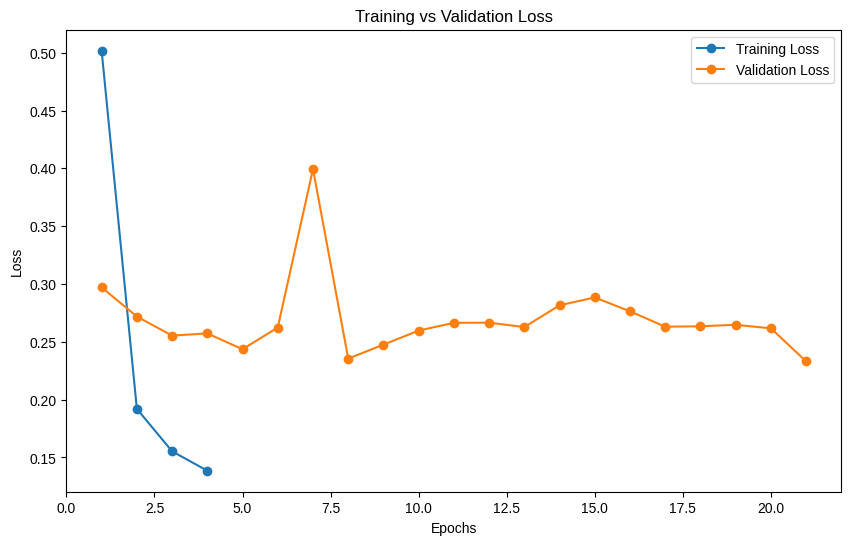

In [ ]:
# Extract logs from the trainer
training_logs = trainer.state.log_history

# Separate training and validation losses
epochs = list(range(1, len(training_logs) + 1))
train_loss = [log["loss"] for log in training_logs if "loss" in log]
val_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker="o")
plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


1-gram Precision: 76.92%
2-gram Precision: 50.00%
3-gram Precision: 27.27%
4-gram Precision: 20.00%

In [ ]:
from sacrebleu import corpus_bleu

# Evaluate translations against references
bleu = corpus_bleu(generated_translations, reference_translations)
print(f"Corpus BLEU Score: {bleu.score}")
print(f"Precisions: {bleu.precisions}")
print(f"Brevity Penalty: {bleu.bp}")


Corpus BLEU Score: 38.058030016749456
Precisions: [76.92307692307692, 50.0, 27.272727272727273, 20.0]
Brevity Penalty: 1.0


The BLEU score graph with frequency shows that the translation model's performance is reasonable but still requires improvement. The skewed distribution indicates that the model has stronger performance for some translations while struggling with others. While the BLEU score of around 38.05 is a good starting point for English-to-Amharic translation.

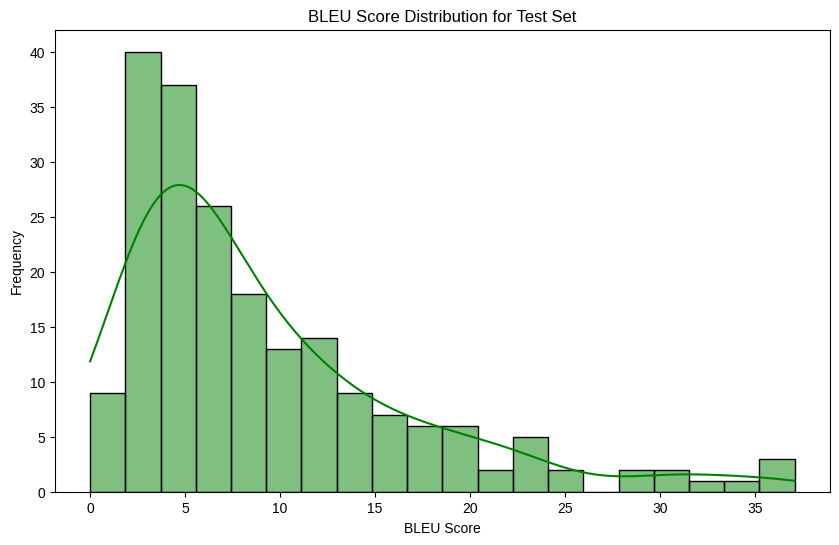

In [ ]:
# BLEU Score Distribution for Test Data
bleu_scores = []
for eng_sentence, ref_sentence in zip(generated_translations, reference_translations):
    # ref_sentence is already a list of strings (containing one string)
    # so no need to further enclose it in another list.
    bleu = corpus_bleu([eng_sentence], [ref_sentence])
    bleu_scores.append(bleu.score)

# Plot BLEU Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(bleu_scores, kde=True, bins=20, color="green")
plt.title("BLEU Score Distribution for Test Set")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()

The scatter plot illustrates the relationship between sentence length and BLEU score for English-to-Amharic translation. BLEU scores are distributed across different sentence lengths without a clear pattern, indicating that sentence length does not significantly influence the translation quality

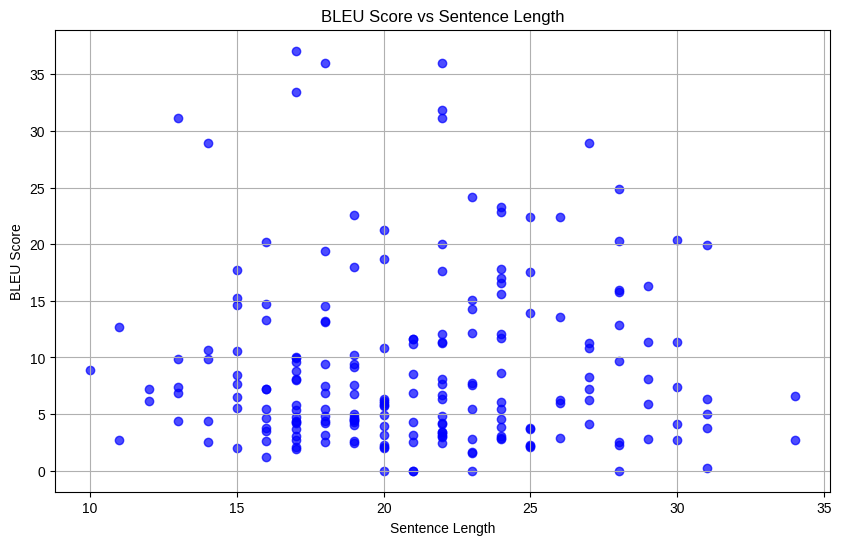

In [ ]:
# BLEU Score vs Sentence Length
sentence_lengths = [len(sentence.split()) for sentence in df["English Sentence"]]

plt.figure(figsize=(10, 6))
plt.scatter(sentence_lengths[:len(bleu_scores)], bleu_scores, alpha=0.7, color="blue")
plt.title("BLEU Score vs Sentence Length")
plt.xlabel("Sentence Length")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()


**challenges**

Dataset Size: With only 2500 lines, the dataset was relatively small, limiting the model's ability to generalize effectively.

Tokenization Mismatch: Using SentencePieceProcessor caused a mismatch between tokenized and padded English and Amharic vocabularies. Padding resolved part of the issue.

Training from Scratch: Training the model from scratch was difficult, so the Helsinki-NLP/opus-mt-en-mul pre-trained model from Hugging Face was used as a foundation.

Training Errors: Training with custom tokenization led to errors, so the pre-trained Helsinki-NLP/opus-mt-en-mul tokenizer was adopte

Out of Memory (OOM) Issues: Memory limitations occurred during training, which were resolved by reducing the batch size and increasing gradient accumulation steps to optimize resource usage.

Amharic Complexity: Amharic's complex grammar and morphology presented challenges for accurate translations.

Overfitting and Underfitting: One of the main challenges was avoiding overfitting or underfitting the model. Striking the right balance in model complexity and the amount of training data was necessary to improve the generalization capability of the model.

Hyperparameter Tuning: Finding the best hyperparameters for the translation model was challenging and required multiple iterations to optimize the learning rate, batch size, and other parameters.

Sentence Length and Complexity: The model sometimes struggled with translating longer or more complex sentences accurately. Simple sentences worked well, but maintaining accuracy with more involved structures required additional training and adjustments.

***improvments***

Larger and More Diverse Dataset: To improve translation accuracy, incorporating a larger dataset with more varied topics, sentence structures, and vocabulary would be beneficial. This would help the model handle a wider range of text and improve its ability to translate complex or idiomatic sentences.

Advanced Models: Implementing more advanced and state-of-the-art models such as Transformer-based architectures (e.g., Transformer, GPT, BERT) could improve the quality of translations. These models have shown significant improvements in language understanding and translation tasks.

Real-Time Suggestions and Corrections: Adding a feature where the system provides real-time feedback or suggestions during the translation process can make it more interactive and engaging.

use Rule-based training can improve your model by fixing grammar issues, ensuring consistency, resolving ambiguities, and augmenting data. Combining it with neural models can refine translations, especially for complex languages like Amharic. However, it can be challenging to scale and maintain.

**conclusion**

 English-to-Amharic translation model, integrated with a website for easy access, successfully utilizes the Helsinki-NLP/opus-mt-en-mul pre-trained model. It addresses challenges like tokenization mismatches and memory constraints through optimizations such as reducing batch sizes and increasing gradient steps. While the model achieves a BLEU score of 38.05 with 2500 sentences, there is still room for improvement, particularly in handling complex Amharic grammar. The website's integration allows users to easily interact with the model for real-time translations. Future enhancements could focus on improving data quality, expanding the dataset, and integrating rule-based methods to refine accuracy and support additional languages, making the tool an even more powerful resource for language learning and cross-cultural communication.

**Integration of English-to-Amharic Translation Model into a Web Application**


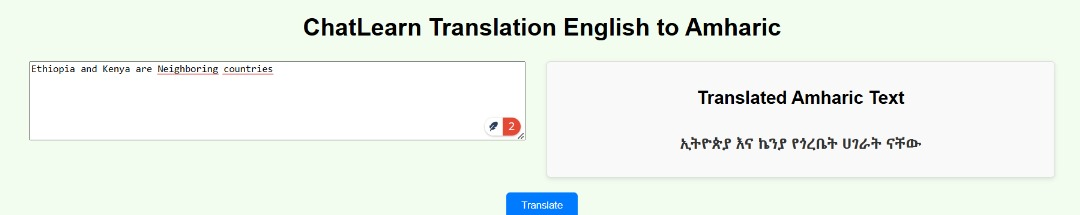
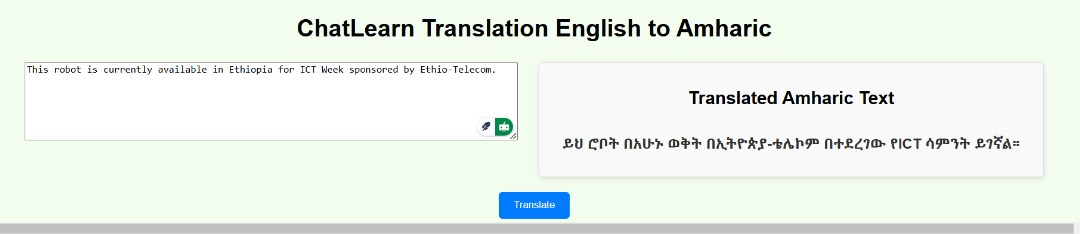

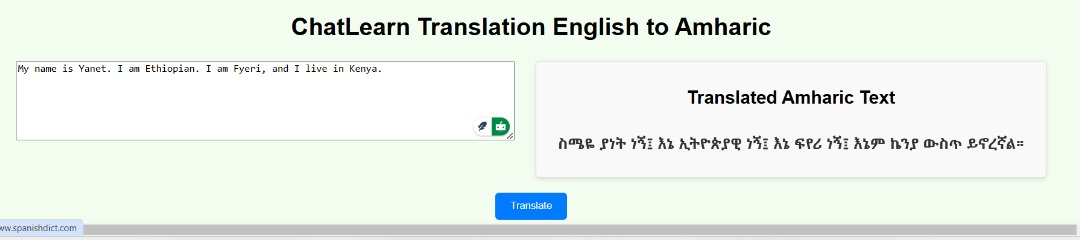